# Homework from Big Data Federation

1. Please write a program to fetch the historical prices and dates of gold and silver from these 2 URLs:

    * https://www.investing.com/commodities/gold-historical-data
    * https://www.investing.com/commodities/silver-historical-data

    and store them locally (in a file or database, as you see fit).
    (You can just extract the default data range in each case: no need to interact with the UI elements.)


2. Please then write a second program that takes the following 3 command line arguments:

    * Start date (in the format 2017-05-10)
    * End date (in the format 2017-05-22)
    * Commodity type (either "gold" or silver”)

    and then returns (via the locally stored data) the mean and variance of the commodity’s price over the specified date range.

    For example, the program might be called like so:
    ./getCommodityPrice 2017-05-01 2017-05-03 gold
    and would print out a tuple such as:
    gold 1253.66 35.79


3. As the last step, please write a program to help you decide if the previous gold or silver prices are good predictors for their future prices.
    Also do the same to check if an increase or decrease in the price is predictable. (There is no need to do the actual prediction.)

## 1. Fetch historical prices and dates of gold and silver

The class below (`HistoricalData`) is created to fetch historical data from the web site https://www.investing.com/.

After instantiating an object of the class, the method `read_table(commodoty_type)` stores the historical data of the specified commodoty into a pandas data frame.

In [1]:
from lxml import html
import requests
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


class HistoricalData():
    
    def __init__(self):
        self.headers = requests.utils.default_headers()
        self.headers.update(
            {'User-Agent': 
                 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_4) '
                 'AppleWebKit/537.36 (KHTML, like Gecko) '
                 'Chrome/64.0.3282.186 Safari/537.36',
            }
        )
        self.url = 'https://www.investing.com/commodities'

    def read_table(self, commodity_type='gold'):
        url = '{url}/{commodity}-historical-data'.format(url=self.url, 
                                                         commodity=commodity_type)
        page = requests.get(url, headers=self.headers)
        tree = html.fromstring(page.content)
        table = tree.xpath('//*[@id="results_box"]/table[1]')[0]
        raw_html = html.tostring(table)
        df = pd.read_html(raw_html, header=0)[0]
        df['Date'] = pd.to_datetime(df['Date'])
        return df.sort_values(by='Date', ascending=True).set_index('Date')

In [2]:
hd = HistoricalData()
gold_df = hd.read_table('gold')
silver_df = hd.read_table('silver')

In [3]:
gold_df.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2018-02-07,1314.6,1326.6,1334.8,1313.5,351.23K,-1.12%
2018-02-08,1319.0,1320.7,1324.5,1309.0,365.93K,0.33%
2018-02-09,1315.7,1321.0,1325.0,1313.2,317.67K,-0.25%
2018-02-12,1326.4,1317.1,1330.0,1316.3,208.07K,0.81%
2018-02-13,1330.4,1325.0,1333.5,1323.7,201.43K,0.30%


In [4]:
silver_df.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2018-02-07,16.206,16.630,16.630,16.630,0.00K,-2.07%
2018-02-08,16.395,16.355,16.425,16.190,-,1.17%
2018-02-09,16.310,16.395,16.400,16.130,-,-0.52%
2018-02-11,16.320,16.295,16.325,16.280,-,0.06%
2018-02-12,16.548,16.375,16.375,16.345,0.00K,1.40%


## 2. Function that return mean and variance given the Start date, End date, Commodoty type

In [5]:
def getCommodityPrice(start_date, end_date, commodoty_type):
    df = HistoricalData().read_table(commodoty_type)
    window_df = df[start_date:end_date]['Price']
    return window_df.mean(), window_df.std()**2

In [6]:
getCommodityPrice('2018-02-20','2018-02-28', 'gold')

(1327.9428571428573, 44.636190476190336)

In [7]:
getCommodityPrice('2018-02-20','2018-02-28', 'silver')

(16.46, 0.00915485714285713)

## 3. Models to predict prices, and change

This is a very complex task, that financial researchers are tackling since long. Therefore, I do not pretend to really solve this task within this homework. Rather, what follow is the development of a class that allows to run different machine learning models on a selected set of features. The class, depending on the input parameters, can test price predictions, as well as increase/decrease predictions.   

### Exploratory data analysis

Here there is some exploratory data analysis. As first, let's have a look at the plots of the  gold and silver price time series.

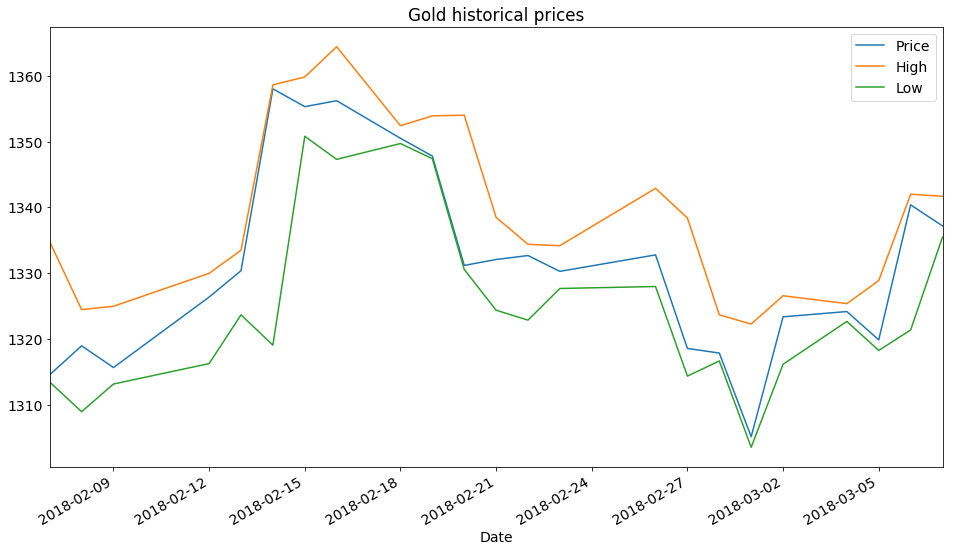

In [8]:
import matplotlib
matplotlib.rcParams.update({'font.size': 14})
gold_df[['Price','High','Low']].plot(figsize=(16,9), title='Gold historical prices');

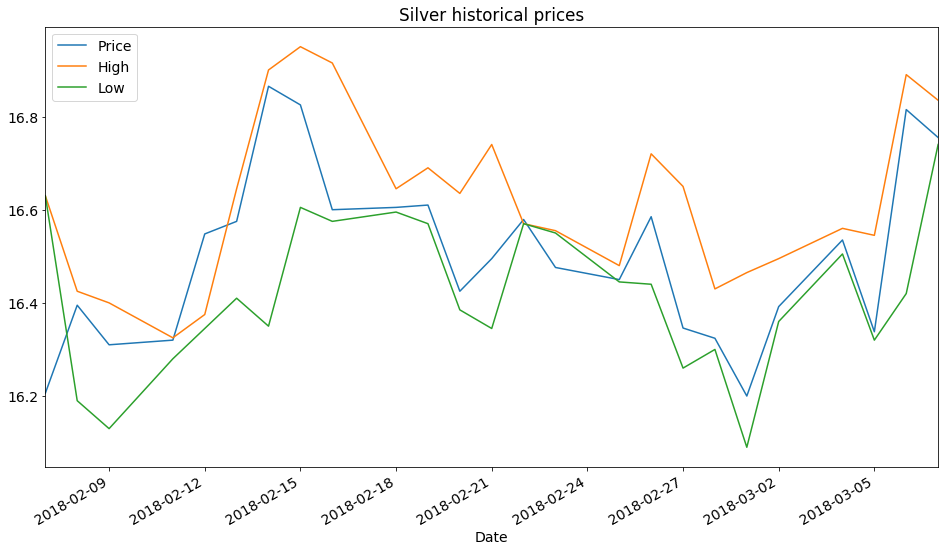

In [9]:
silver_df[['Price','High','Low']].plot(figsize=(16,9), title='Silver historical prices', );

We can notice that the plot of the silver is a bit messy. 
There are dates for which the Price is lower or higher than the Low or High, respectively
(for example, on Feb. 07 and on Feb. 12).
We are going to fix it modifying the High and Low as follow, and replot.

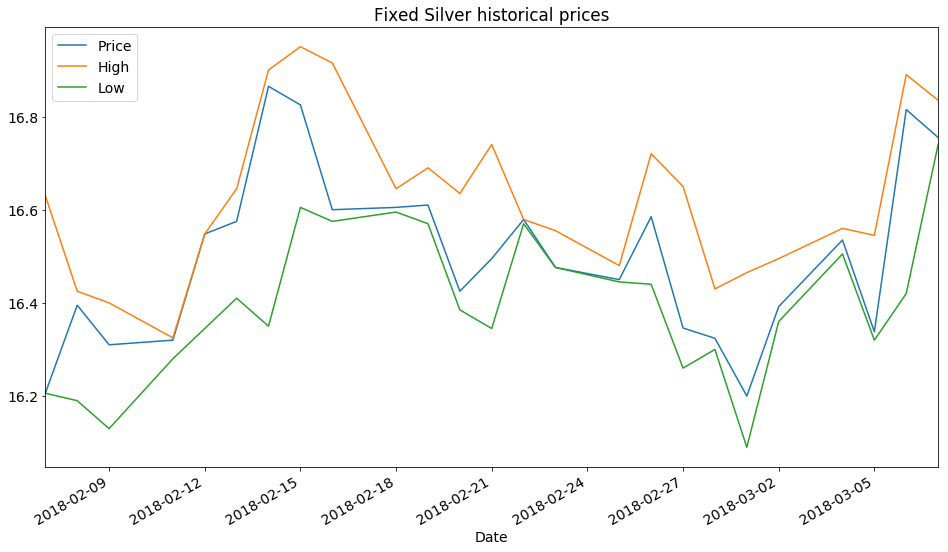

In [10]:
silver_df['High'] = silver_df[['Price','High']].max(axis=1)
silver_df['Low'] = silver_df[['Price','Low']].min(axis=1)
silver_df[['Price','High','Low']].plot(figsize=(16,9), title='Fixed Silver historical prices');

#### Silver and Gold correlation

From the plots above, looks like that the prices of the Gold and the Silver are very correlated. Indeed, in the following plot we measure a correlation parameters of 0.86.

We can take advantage of it. After a proper scaling, the prices of Gold and Silver can be joined in a single dataset to train the prediction models. In this way, we have a single model ables to predict either the Gold and the Silver prices, rather than two distinct models. This is an idea that can be developped further with large dataset, working on commodoty trend similarities.    

Gold Silver correlation index =  0.865621233254


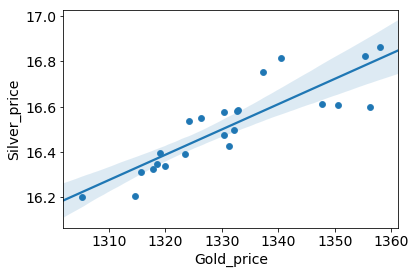

In [11]:
import seaborn.apionly as sb

price_corr_df = pd.concat([gold_df['Price'], silver_df['Price']], axis=1, join='inner')
price_corr_df.columns = ['Gold_price', 'Silver_price']
price_corr_df.plot.scatter('Gold_price', 'Silver_price')
sb.regplot(price_corr_df['Gold_price'],price_corr_df['Silver_price'])

correlation = price_corr_df['Gold_price'].corr(price_corr_df['Silver_price'])
print 'Gold Silver correlation index = ', correlation

### Preparing the dataset for the model

The class `FeaturesBuilder` builds the features for each commodoty type to be used in the model. From a time windows soon preceeding the prediction day, the following features are selected:
* Price mean 
* Price standard deviation
* Price EWMA
* Change mean
* Change standard deviation
* The Price and the Change of each day in the time windows

The width of the time windows is set by the parameter `previous_days`. We will work with a 3 days time windows. 

In [12]:
from sklearn.preprocessing import StandardScaler
import numpy as np

class FeaturesBuilder():
    
    def __init__(self, df, previous_days):
        self.previous_days = previous_days
        self.df = df.copy()
        self.features(df.copy())
        self.scaler = StandardScaler().fit(self.ft_df)
        self.scaled_db = self.scaler.transform(self.ft_df)
        
    def features(self, ft_df):
        ft_df['Change %'] = ft_df['Change %'].apply(lambda x: x.strip(' %')).astype('float')
        ft_df[['Price_mean','Change_mean']] = \
            ft_df[['Price','Change %']].shift(1).rolling(window=self.previous_days).mean()
        ft_df[['Price_std','Change_std']] = \
            ft_df[['Price','Change %']].shift(1).rolling(window=self.previous_days).std()
        ft_df['ewma'] = ft_df[['Price']].shift(1).ewm(span=self.previous_days).mean()
        
        for i in range(self.previous_days):
            ft_df[['Price-{}'.format(i+1),'Change-{}'.format(i+1)]] = \
                ft_df[['Price','Change %']].shift(i+1)
        self.ft_df = ft_df.drop(['Open','High','Low','Vol.'], axis=1)[self.previous_days:]
    
    def get_scaled_db(self):
        return self.scaled_db

The dataframe below contains the selected features, starting from the third column.
The first column `Price` is the target for the price prediction model.
The second column `Change %` is the target for the Increase/Decrease prediction model.

In [13]:
fb_gold = FeaturesBuilder(gold_df, previous_days=3)
fb_gold.ft_df.head()

,Price,Change %,Price_mean,Change_mean,Price_std,Change_std,ewma,Price-1,Change-1,Price-2,Change-2,Price-3,Change-3
Date,,,,,,,,,,,,,
2018-02-12,1326.4,0.81,1316.433333,-0.346667,2.289833,0.729817,1316.485714,1315.7,-0.25,1319.0,0.33,1314.6,-1.12
2018-02-13,1330.4,0.30,1320.366667,0.296667,5.479355,0.530786,1321.773333,1326.4,0.81,1315.7,-0.25,1319.0,0.33
2018-02-14,1358.0,2.07,1324.166667,0.286667,7.600219,0.530126,1326.225806,1330.4,0.30,1326.4,0.81,1315.7,-0.25
2018-02-15,1355.3,-0.20,1338.266667,1.060000,17.206200,0.911098,1342.365079,1358.0,2.07,1330.4,0.30,1326.4,0.81
2018-02-16,1356.2,0.07,1347.900000,0.723333,15.215453,1.192742,1348.883465,1355.3,-0.20,1358.0,2.07,1330.4,0.30


### Building a class to run ML models

The class `RunningModel` allows to quickly select the problem to solve (Price or Increase/Decrease prediction), and to apply different ML models.

In [14]:
import itertools
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import cross_val_score, train_test_split

class RunningModel(HistoricalData):
    
    def __init__(self, commodity_list, previous_days, target, model):
        """
        :param commodity_list: list of the commodoty types 
                               to join together in a single database.
        :param previous_days: define the width of the time windows.
        :param target: define the problem to solve. 'price' for price prediction,
                       'change' for Increase/Decrease prediction.
        :param model: machine learning model
        """
        HistoricalData.__init__(self)
        self.previous_days = previous_days
        self.model = model
        self.target = target
        self.commodity_features = {}
        self.commodity_db = {}
        self.commodity_df = {}
        self.prepare_dataset(commodity_list)
        self.target_features()
        
    def prepare_dataset(self, commodity_list):
        for commodity in commodity_list:
            self.commodity_df[commodity] = self.read_table(commodity)
            self.commodity_df[commodity]['High'] = \
                self.commodity_df[commodity][['Price','High']].max(axis=1)
            self.commodity_df[commodity]['Low'] = \
                self.commodity_df[commodity][['Price','Low']].min(axis=1)
            self.commodity_features[commodity] = \
                FeaturesBuilder(self.commodity_df[commodity], self.previous_days)
            self.commodity_db[commodity] = self.commodity_features[commodity].get_scaled_db()
        self.dataset = \
            np.concatenate([self.commodity_db[commodity] for commodity in commodity_list], 
                           axis=0)
        
    def target_features(self):
        self.Features = self.dataset[:,2:]
        if self.target == 'price':
            self.Target = self.dataset[:,0]
        elif self.target == 'change':
            self.Target = (self.dataset[:,1]>0).astype(int)
        else: 
            raise Exception(
                "Error: target can be 'price' or 'change'")
    
    def running_model(self):
        self.X_train, self.X_test, self.y_train, self.y_test = \
            train_test_split(self.Features, self.Target, test_size=0.3, random_state=1)
        self.model.fit(self.X_train, self.y_train)
    
    def price_estimator(self):
        y_pred = self.model.predict(self.X_train)
        print 'RMSE on train data:', np.sqrt(metrics.mean_squared_error(self.y_train, y_pred))
        y_pred = self.model.predict(self.X_test)
        print 'RMSE on test data:', np.sqrt(metrics.mean_squared_error(self.y_test, y_pred))

    def price_visualizzation(self, commodity_type): 
        db = self.commodity_db[commodity_type]
        scaler = self.commodity_features[commodity_type].scaler
        df = self.commodity_df[commodity_type]
        np.concatenate((np.array([self.model.predict(db[:,2:])]).T, db[:,1:]), axis=1)
        predicted = scaler.inverse_transform(
            np.concatenate((np.array([self.model.predict(db[:,2:])]).T, db[:,1:]), axis=1))
        df['Predicted_price'] = np.append(np.zeros(self.previous_days), predicted[:,0])
        df[['Price','High','Low','Predicted_price']][self.previous_days:].plot(figsize=(16,9))
        band = (abs(df['Predicted_price'] - df['Price'])
                /(df['High'] - df['Low']))[self.previous_days:].mean()
        print 'Band conteinment index: ', band
            
            
    def variation_estimator(self):
        for X, y, label in [[self.X_train, self.y_train, 'Train'], 
                            [self.X_test, self.y_test, 'Test']]:
            y_pred = self.model.predict(X)
            cnf_matrix = metrics.confusion_matrix(y, y_pred)
            accurancy = float(cnf_matrix[0][0] + cnf_matrix[1][1])/cnf_matrix.sum()
            print 'Accurancy {label} = {acc}'.format(label=label, acc=accurancy)
            self.plot_confusion_matrix(cnf_matrix, '{} dataset'.format(label))
        
    def plot_confusion_matrix(self, cm,
                              title='Confusion matrix',
                              cmap=plt.cm.Blues):
        
        classes = ['decrease','increase']
        plt.figure()
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        tick_marks = np.arange(2)
        plt.xticks(tick_marks, classes)
        plt.yticks(tick_marks, classes)

        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

### Running a linear model to predict prices

First task we are going to tackle is the price prediction. We use a Linear Regression model.

To measure the goodness of the result we rely on the RMSE estimator, which the closer to 0 the better.
* First we calculate the RMSE on the training set to measure the goodness of the fit.
* Then we calulate the RMSE on the test set to measure the power of prediction.

In [15]:
ml = RunningModel(['gold','silver'], 
                  previous_days=3, 
                  target='price', 
                  model=linear_model.LinearRegression())

In [16]:
ml.running_model()
ml.price_estimator()

RMSE on train data: 0.556885196973
RMSE on test data: 1.10004823088


### Visual inspection

The results above looks promising. Let's have a visula inspection.
In the plots below the predictions is represented by the red line. It is not very accurate (as expected), but at least follow the trend, and most of the time it is within the Low-High band.
Actually, we can define an estimator that gives us a measure of how well the predictions are within the Low-High band. It is defined as 

$ B = \frac{1}{N} \sum{\frac { | Predicted\_Price - Price | } { | High-Low | }} $

Band conteinment index:  0.667283056022
Band conteinment index:  1.52317935305


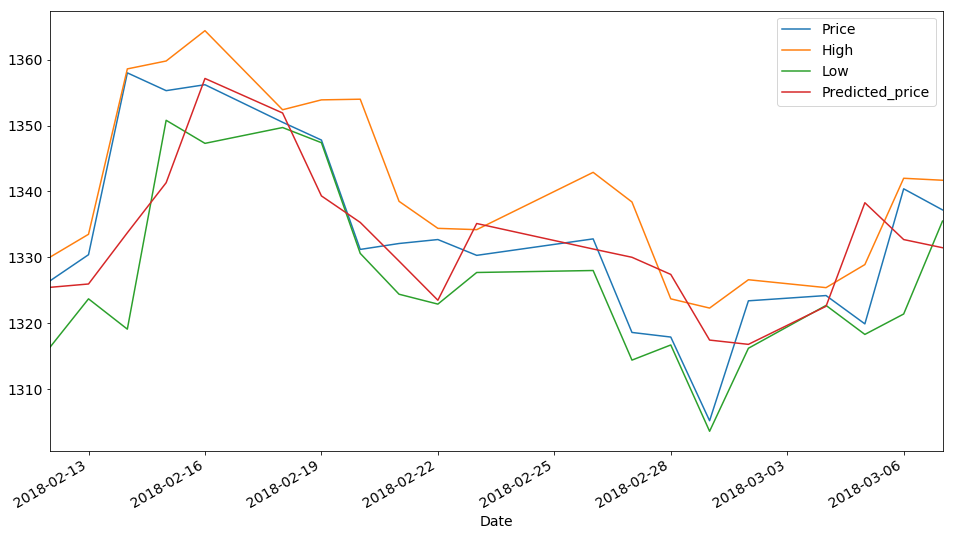

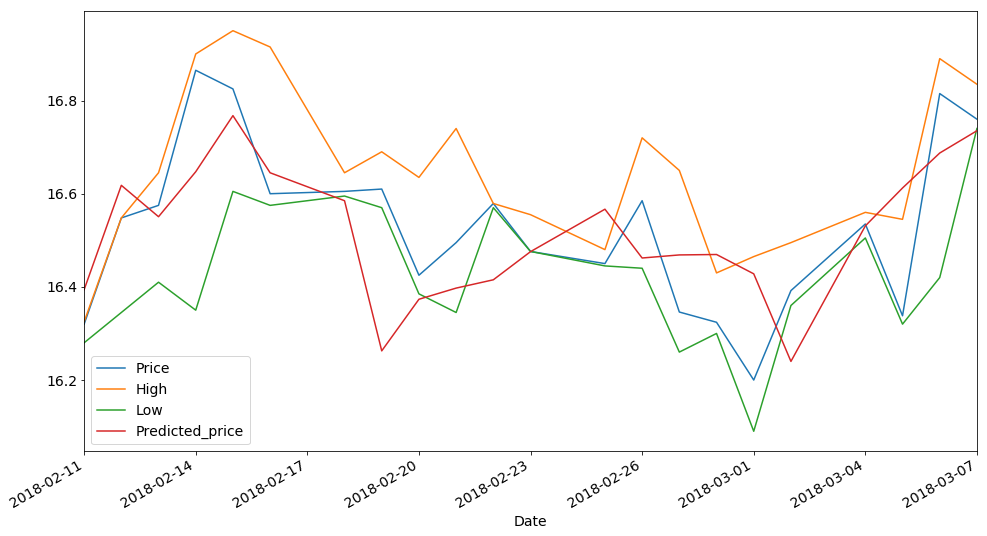

In [17]:
ml.price_visualizzation('gold')
ml.price_visualizzation('silver')

### Running a model to predict increase or decrease

While the previous task required a regression, the Increase/Decrease is a classification problem. To solve it we are using the same features defined above. The target instead id the `Change %` column (see feature db above) transformed in binary (0 for negative Changes, 1 for positive Changes).

We use the class `RunningModel` developped above, giving as model an SVM with RBF Kernel.
The results are inspectioned with the confusion matrix for either the train and test dataset.
Actually, what we are really interested in this case is the accurancy, which corresponds to the fraction of correct predictions.

In [18]:
from sklearn import svm
ml = RunningModel(['gold','silver'], 
                  previous_days=3, 
                  target='change', 
                  model=svm.SVC(kernel='rbf', C=2))
ml.running_model()

Accurancy Train = 0.931034482759
Accurancy Test = 0.769230769231


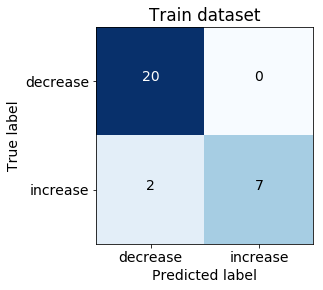

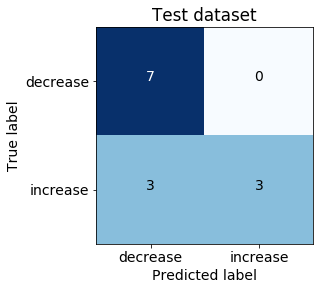

In [19]:
ml.variation_estimator()